In [1]:
import pandas as pd
import numpy as np
import qiime2 as q2
import biom

In [11]:
# load metadata 
consolidated_md = pd.read_csv('/projects/thdmi/metadata/consolidated_metadata_subset.tsv', sep='\t', index_col=0)

/tmp/ipykernel_194691/1524862654.py:2: DtypeWarning: Columns (1511) have mixed types. Specify dtype option on import or set low_memory=False.
  consolidated_md = pd.read_csv('/projects/thdmi/metadata/consolidated_metadata_subset.tsv', sep='\t', index_col=0)


In [12]:
md_filtered = pd.read_csv('/home/lakhatib/3country/final_scripts/data_cleaning/subsetted_md.tsv', sep = '\t', index_col=0)

/tmp/ipykernel_194691/2900739309.py:1: DtypeWarning: Columns (45,48,64,70,71,72,73,113,119,140,142,160,165,167,177,195,198,200,201,224,252,261,265,266,284,285,300,304,305,306,315,316,319,321,325,328,329,341,342,347,351,354,358,361,368,369,370,374,376,380,384,389,390,397,399,407,408,416,428,431,438,443,446,450,455,460,461,462,463,464,465,470,475,481,485,487,493,504,543,549,562,573,582,585,591,598,602,607,611,612,613,637,643,667,687,697,698,707,708,709,720,727,737,739,743,748,760,769,773,806,809,813,840,844,850,852,870,874,891,892,899,910,912,924,925,926,933,936,940,946,953,955,956) have mixed types. Specify dtype option on import or set low_memory=False.
  md_filtered = pd.read_csv('/home/lakhatib/3country/final_scripts/data_cleaning/subsetted_md.tsv', sep = '\t', index_col=0)


In [13]:
md = consolidated_md.loc[consolidated_md.index.intersection(md_filtered.index)]

In [14]:
# of the categorical columns, remove those that do not have at least 2 categories with 50 people in them 
cat_columns = md.dtypes[(md.dtypes != 'float64')].index
cat_to_remove = []
for c in cat_columns: 
    if len(md[c].dropna().unique()) < 2: 
        cat_to_remove.append(c)
    elif md[c].value_counts().min() < 5: 
        cat_to_remove.append(c) 

# also remove columns that are only present in one thdmi cohort
only_one_thdmi_cohort = []
for c in md.columns: 
    sub_md = md.loc[md[c].notna()] 
    if len(sub_md.thdmi_cohort.unique()) == 1: 
        only_one_thdmi_cohort.append(c) 

md.drop(columns = cat_to_remove + only_one_thdmi_cohort, inplace=True)    

# rename columns
md.columns = [c.replace('+', 'and').replace('=', 'to').replace('[', '_').replace(']', '_').replace(';', '_').replace('&', 'and').replace('/', 'or').replace(' ', '') for c in md.columns]

In [15]:
for c in md.columns[md.columns.str.startswith('Processed_Calories')]: 
    md[c] = md[c] * md['Amount_Energy_in_kcal'] * (1/100)
for c in md.columns[md.columns.str.startswith('Processed_Grams')]: 
    md[c] = md[c] * md['Amount_Total_Grams_in_g'] * (1/100)
for c in ['Processed_Calories_Nova_processed_foods', 'Processed_Calories_Nova_ultra_processed_foods', 'Processed_Calories_Nova_unprocessed_or_minimally_processed_foods']:
    md[c + '_per1000kcal'] = md[c] * (1000 / md['Amount_Energy_in_kcal'])

/tmp/ipykernel_194691/1327185151.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  md[c + '_per1000kcal'] = md[c] * (1000 / md['Amount_Energy_in_kcal'])
/tmp/ipykernel_194691/1327185151.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  md[c + '_per1000kcal'] = md[c] * (1000 / md['Amount_Energy_in_kcal'])
/tmp/ipykernel_194691/1327185151.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

In [16]:
md.rename_axis(index='SampleID', inplace=True)
md.to_csv('subsetted_md.tsv', sep='\t')

In [18]:
columns_to_examine = md.columns.difference(['thdmi_cohort'])
pd.DataFrame(data={'columns': columns_to_examine}).to_csv("cols_for_examination.csv")

In [19]:
# total fermented: sum all the ones with Collapsed_Fermented
# total processed: Processed_Calories_Nova_processed_foods, Processed_Grams_Nova_processed_foods
# total ultraprocessed: Processed_Calories_Nova_ultra_processed_foods / Processed_Grams_Nova_ultra_processed_foods
# total minimally processed: Processed_Calories_Nova_unprocessed_or_minimally_processed_foods / Processed_Grams_Nova_unprocessed_or_minimally_processed_foods
# HEI positive scores: 	Hei2015_TotalHEIScore - negative scores
# HEI negative scores: Hei2015_AddedSugars, Hei2015_SaturatedFat, Hei2015_Sodium, Hei2015_RefinedGrains

md['Total_Fermented'] = md.filter(like='Collapsed_Fermented').sum(axis=1)

md.rename(columns={'Processed_Calories_Nova_processed_foods': 'Total_Calories_Processed_Foods', 
                   'Processed_Grams_Nova_processed_foods': 'Total_Grams_Processed_Foods', 
                   'Processed_Calories_Nova_ultra_processed_foods': 'Total_Calories_Ultraprocessed_Foods', 
                   'Processed_Grams_Nova_ultra_processed_foods': 'Total_Grams_Ultraprocessed_Foods', 
                   'Processed_Calories_Nova_unprocessed_or_minimally_processed_foods': 'Total_Calories_Minimally_Processed_Foods', 
                   'Processed_Grams_Nova_unprocessed_or_minimally_processed_foods': 'Total_Grams_Minimally_Processed_Foods', 
                   'Amount_Energy_in_kcal': 'Total_Calories_Per_Day', 
                   'host_body_mass_index': 'BMI', 
                   'host_age': 'Age', 
                   'Hei2015_TotalHEIScore': 'HEI_2015_Score', 
                   'covid_level_of_wellbeing_coded': 'Level_of_Wellbeing', 
                   'antibiotic_history_coded': 'Antibiotic_History_Coded',
                  }, 
          inplace=True)
#md['Total_HEI_Moderation'] = md['Hei2015_AddedSugars'] + md['Hei2015_SaturatedFat'] + md['Hei2015_Sodium'] + md['Hei2015_RefinedGrains']
#md['Total_HEI_Adequacy'] = md['Hei2015_TotalHEIScore'] - md['Total_HEI_Moderation']

In [20]:
hei_data = md.filter(like='Hei2015_')
hei_data = hei_data.merge(md[['thdmi_cohort']], right_index=True, left_index=True)
for_radarplot = md[['Total_Calories_Processed_Foods', 'Total_Grams_Processed_Foods', 
                    'Total_Calories_Ultraprocessed_Foods', 'Total_Grams_Ultraprocessed_Foods', 
                    'Total_Calories_Minimally_Processed_Foods',
                    'Total_Grams_Minimally_Processed_Foods', 'Total_Fermented', 
                    'Total_Calories_Per_Day', 'BMI', 'Age', 'HEI_2015_Score', 
                    'Level_of_Wellbeing', 'Antibiotic_History_Coded']]

In [21]:
hei_data.to_csv('hei_for_radar.csv')

In [22]:
from scipy.stats import zscore
radar_normalized = for_radarplot.apply(zscore, nan_policy='omit')
radar_normalized = radar_normalized.merge(md[['thdmi_cohort']], right_index=True, left_index=True)

In [23]:
df = radar_normalized.groupby('thdmi_cohort').mean()

In [24]:
radar_normalized.to_csv('for_radar_plot.csv')

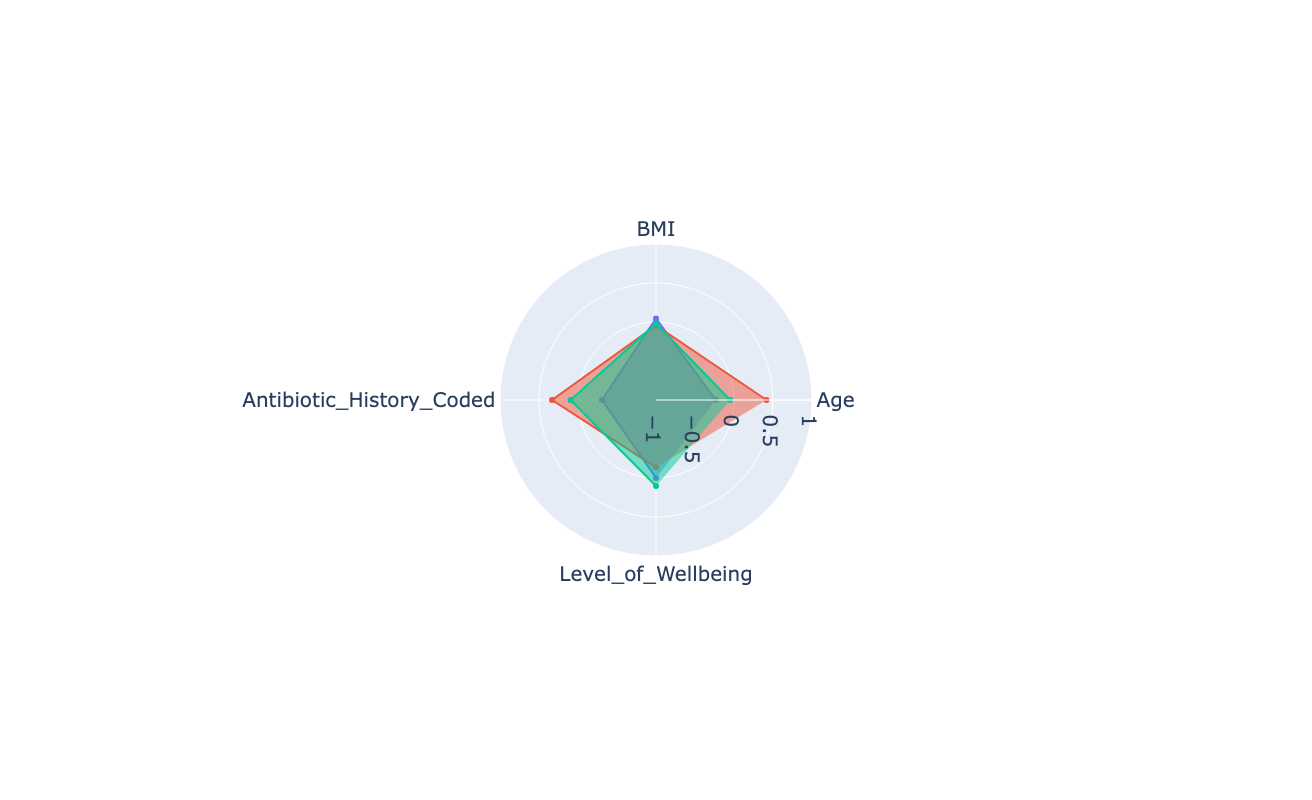

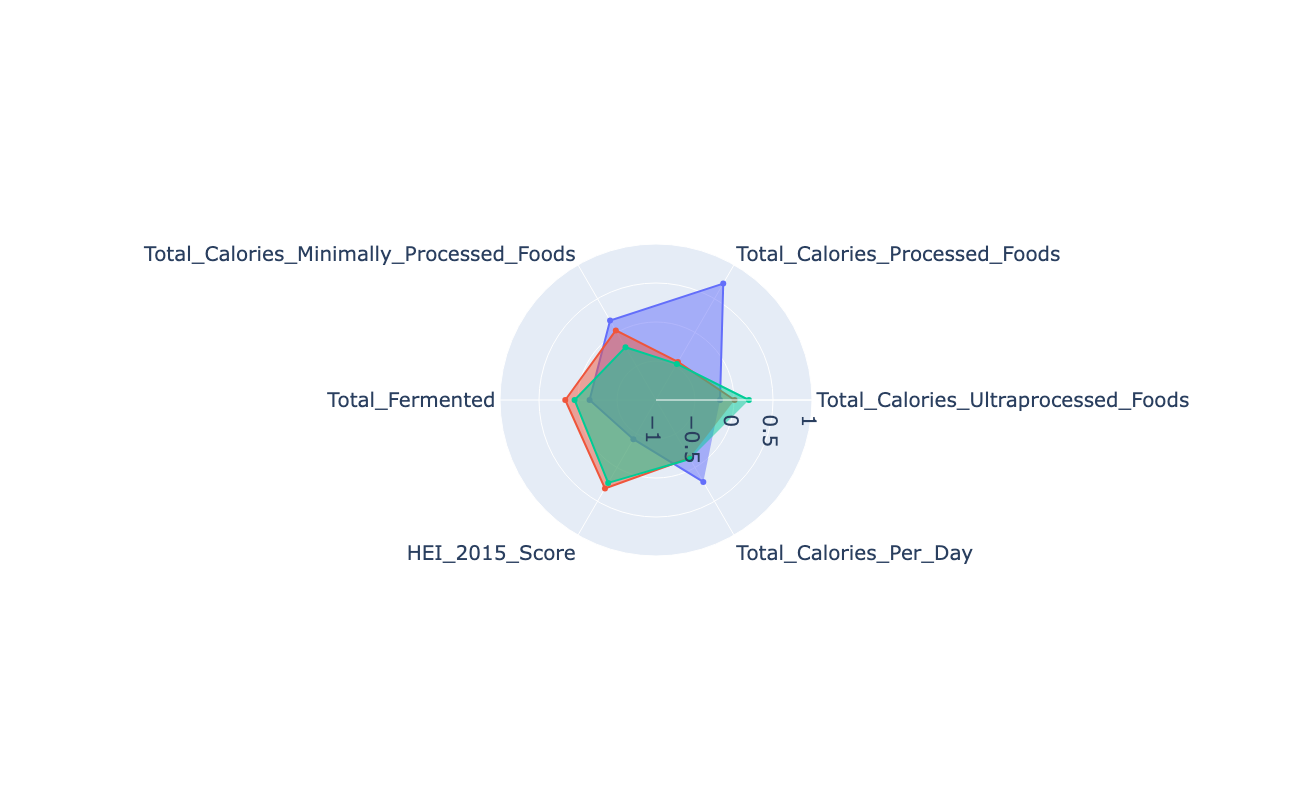

In [26]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Reorder the columns for Plot C to match the order in the image (Age at the top, BMI on the right, etc.)
columns_group1 = ['Age', 'BMI', 'Antibiotic_History_Coded', 'Level_of_Wellbeing']

# Reorder the columns for Plot D to match the image (Ultraprocessed Foods on the right)
columns_group2 = ['Total_Calories_Ultraprocessed_Foods', 'Total_Calories_Processed_Foods', 
                  'Total_Calories_Minimally_Processed_Foods', 'Total_Fermented', 
                  'HEI_2015_Score', 'Total_Calories_Per_Day']

# Radar chart for first group (Plot C)
fig_c = go.Figure()

for country in df.index:
    fig_c.add_trace(go.Scatterpolar(
        r=df.loc[country, columns_group1],
        theta=columns_group1,
        fill='toself',
        name=country
    ))

fig_c.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[-1, 1])
    ),
    font=dict(size=20),
    margin=dict(l=500, r=500, t=150, b=150),
    showlegend=False,
    height=800,  # Adjust height
    width=800    # Adjust width
)

# Radar chart for second group (Plot D)
fig_d = go.Figure()

for country in df.index:
    fig_d.add_trace(go.Scatterpolar(
        r=df.loc[country, columns_group2],
        theta=columns_group2,
        fill='toself',
        name=country
    ))

fig_d.update_layout(
    polar=dict(
        radialaxis=dict(visible=True, range=[-1, 1])
    ),
    font=dict(size=20),
    margin=dict(l=500, r=500, t=150, b=150),
    showlegend=False,
    height=800,  # Adjust height
    width=800    # Adjust width
)

# Save Plot C with high resolution (2400x2400 pixels for 400 DPI)
fig_c.write_image("../final_figures/figure1c_plot_c_high_res.png", width=1600, height=1600, scale=3)

# Save Plot D with high resolution (2400x2400 pixels for 400 DPI)
fig_d.write_image("../final_figures/figure1c_plot_d_high_res.png", width=1600, height=1600, scale=3)

# Show plots
fig_c.show()
fig_d.show()